# Initial EDA 

This is a short notebook to look at the available data provided and to see if we can determine which test failures appear to be correlated with each other. 

In this notebook we will:

1. Load and rearrange our dataset
2. Encode our data with a binary encoding scheme
3. Analyze data looking for highly correlated failure sets
4. Example: Given a test failure of interest return other test failures that are highly correlated.
5. Output a csv file that contains a list of highly correlated test sets and their associated job run urls


### Load and arrange dataset   

This data is a nested json, where we are mainly interested in the field "failureGroups", so we will slice to only that row, which is a dictionary, then unroll that into its own dataframe for analysis. 

In [1]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

/home/mcliffor/anaconda3/envs/devenv/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
d = pd.read_json("../../../data/external/sippydata.json", orient="index")
d.columns = ["data"]
d

,data
release,
all,"{'all': {'successes': 477806, 'failures': 8619..."
ByPlatform,"{'aws': {'successes': 196148, 'failures': 3249..."
ByJob,{'canary-release-openshift-origin-installer-e2...
BySig,"{'sig-api-machinery': {'successes': 45866, 'fa..."
failureGroups,[{'job': 'release-openshift-origin-installer-e...
jobPassRate,[{'name': 'release-openshift-ocp-installer-e2e...
timestamp,2020-08-10T12:10:38.344952931-04:00
topFailingTestsWithBug,[{'name': '[sig-arch][Feature:ClusterUpgrade] ...
topFailingTestsWithoutBug,[{'name': '[sig-network] network isolation whe...


In [3]:
# unroll the failuregroups data

failure_groups = pd.DataFrame(d.loc["failureGroups"][0])
failure_groups.head()

,job,url,testGridJobUrl,testFailures,failedTestNames,failed,hasUnknownFailures,succeeded
0,release-openshift-origin-installer-e2e-azure-4.6,https://prow.svc.ci.openshift.org/view/gcs/ori...,https://testgrid.k8s.io/redhat-openshift-ocp-r...,371,"[Overall, [sig-apps][Feature:DeploymentConfig]...",True,True,False
1,release-openshift-ocp-installer-e2e-aws-ovn-4.6,https://prow.svc.ci.openshift.org/view/gcs/ori...,https://testgrid.k8s.io/redhat-openshift-ocp-r...,352,"[Overall, [sig-arch] Managed cluster should ha...",True,True,False
2,release-openshift-ocp-installer-e2e-azure-4.6,https://prow.svc.ci.openshift.org/view/gcs/ori...,https://testgrid.k8s.io/redhat-openshift-ocp-r...,294,"[Overall, [k8s.io] Container Runtime blackbox ...",True,True,False
3,release-openshift-ocp-installer-e2e-gcp-ovn-4.6,https://prow.svc.ci.openshift.org/view/gcs/ori...,https://testgrid.k8s.io/redhat-openshift-ocp-r...,264,"[Overall, operator.Run template e2e-gcp - e2e-...",True,True,False
4,release-openshift-origin-installer-e2e-azure-4.6,https://prow.svc.ci.openshift.org/view/gcs/ori...,https://testgrid.k8s.io/redhat-openshift-ocp-r...,224,"[Overall, [sig-apps][Feature:DeploymentConfig]...",True,True,False


In [4]:
failure_groups.shape

(102, 8)

In [5]:
# Grab only the failed test names columns to see if there are any correlations.
failed_test_names = failure_groups.failedTestNames.apply(lambda x: x[1:])

In [6]:
failed_test_names

0      [[sig-apps][Feature:DeploymentConfig] deployme...
1      [[sig-arch] Managed cluster should have no cra...
2      [[k8s.io] Container Runtime blackbox test when...
3      [operator.Run template e2e-gcp - e2e-gcp-ovn c...
4      [[sig-apps][Feature:DeploymentConfig] deployme...
                             ...                        
97     [[sig-arch] Managed cluster should have no cra...
98     [operator.Run template e2e-azure - e2e-azure-o...
99     [operator.Run template e2e-aws-serial - e2e-aw...
100    [operator.Run template e2e-azure - e2e-azure-o...
101    [operator.Run template e2e-azure - e2e-azure-o...
Name: failedTestNames, Length: 102, dtype: object

### What is this data?

It looks like we have 102 ci job runs in our dataset. And for each job run we have list of tests that failed. Our goal here is to develop a method to determine which tests are highly correlated with each other, or in other words, are likely to cooccur. 

So we want to evaluate the occurrence of these tests over all 102 jobs available to us in this dataset. In order to do this, we will encode each job as a vector, where each position represents 1 of the possible tests. Positions with 1 represent the test failed, otherwise it will be 0. This binary encoding scheme should simplify our job later on.   

# Encoding

For our initial approach we are going to consider each test for each job as a feature that is either present (1) or absent (0). This should make comparing job results and test cooccurrence rather straightforward.   

### Build vocab
First thing we need to do is determine how long our feature vector is going to be by collecting the unique test names in our dataset

In [8]:
# build a vocabulary of unique test names across the entire data set.
vocab = []
count = 0
for i in failed_test_names:
    for j in i:
        count += 1
        if j not in vocab:
            vocab.append(j)

print(count)
len(vocab)
# the vocabulary represents about 1/4 of the dataset

5841


1455

In [9]:
# confirm that there are no duplicates in the vocab
len(pd.Series(vocab).unique())

1455

### Apply encoding scheme 

In [10]:
def encode_tests(job):
    encoded = []
    for v in vocab:
        if v in job:
            encoded.extend([1])
        else:
            encoded.extend([0])
    return encoded

In [11]:
encoded = failed_test_names.apply(encode_tests)

In [12]:
encoded

0      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
1      [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, ...
2      [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, ...
3      [1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, ...
4      [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...
                             ...                        
97     [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...
98     [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...
99     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
100    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, ...
101    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: failedTestNames, Length: 102, dtype: object

In [13]:
df_encoded = pd.DataFrame(encoded.array, columns=vocab)
df_encoded.head()

,[sig-apps][Feature:DeploymentConfig] deploymentconfigs adoption will orphan all RCs and adopt them back when recreated,[sig-network][Feature:Router] The HAProxy router should expose prometheus metrics for a route,[sig-builds][Feature:Builds][webhook] TestWebhookGitHubPing,operator.Run template e2e-azure - e2e-azure container test,[sig-builds][Feature:Builds] oc new-app should succeed with an imagestream,[sig-instrumentation][Late] Alerts should have a Watchdog alert in firing state the entire cluster run,[sig-instrumentation][Late] Alerts shouldn't report any alerts in firing state apart from Watchdog and AlertmanagerReceiversNotConfigured,[sig-cli] oc adm must-gather runs successfully,[sig-builds][Feature:Builds] prune builds based on settings in the buildconfig should prune errored builds based on the failedBuildsHistoryLimit setting,[sig-instrumentation] Prometheus when installed on the cluster shouldn't report any alerts in firing state apart from Watchdog and AlertmanagerReceiversNotConfigured [Early],...,[sig-storage] In-tree Volumes [Driver: emptydir] [Testpattern: Dynamic PV (block volmode)] volume-expand should not allow expansion of pvcs without AllowVolumeExpansion property,[sig-storage] In-tree Volumes [Driver: local][LocalVolumeType: dir-link-bindmounted] [Testpattern: Pre-provisioned PV (ntfs)][sig-windows] volumes should allow exec of files on the volume,[sig-storage] In-tree Volumes [Driver: emptydir] [Testpattern: Pre-provisioned PV (default fs)] subPath should support non-existent path,[sig-storage] In-tree Volumes [Driver: gcepd] [Testpattern: Dynamic PV (default fs)] provisioning should provision storage with snapshot data source [Feature:VolumeSnapshotDataSource],operator.Run template e2e-aws-scaleup-rhel7 - e2e-aws-scaleup-rhel7 container test,[sig-storage] In-tree Volumes [Driver: aws] [Testpattern: Dynamic PV (ext4)] volumes should allow exec of files on the volume,[sig-storage] In-tree Volumes [Driver: cinder] [Testpattern: Dynamic PV (block volmode)] volume-expand should not allow expansion of pvcs without AllowVolumeExpansion property,operator.Run template e2e-aws-serial - e2e-aws-serial container test,[sig-storage] CSI Volumes [Driver: csi-hostpath] [Testpattern: Dynamic PV (filesystem volmode)] volumeLimits should support volume limits [Serial],[sig-storage] In-tree Volumes [Driver: azure-disk] [Testpattern: Inline-volume (default fs)] subPath should be able to unmount after the subpath directory is deleted
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


### Confirm no duplicates 

We can see by the empty output below that each job's set of failed tests is unique

In [14]:
# lets confirm that each job is unique in its set of test failures
matches = []
for i, k in enumerate(encoded):
    for j, g in enumerate(encoded):
        if k == g and i != j:
            matches.append((i, j))
print(matches)

[]


### Remove noise/ unique tests

We want to make sure that our correlations are not just due to unique failed test sets present in our small dataset, and want to make sure our tests impact multiple jobs. For example, if we had a unique failed test set that only occurred in a single example, and shared no other failed tests among the vocabulary, then all of the tests would appear to be 100% correlated with each other, when in fact that is merely a consequence of insufficient data.     

In order to prevent that, lets ignore any tests that occur only in a single job.

In order to do that we will use `occurrence_count` to create a filter vector for any test that occurs only once. Then filter them out of our working DF.

In [15]:
# percent that each test is present in the jobs data
perc_present = df_encoded.sum() / len(df_encoded)
perc_present.sort_values(ascending=False).head(3)

[sig-apps][Feature:DeploymentConfig] deploymentconfigs adoption will orphan all RCs and adopt them back when recreated                                                                  0.362745
[sig-arch] Managed cluster should have no crashlooping pods in core namespaces over four minutes                                                                                        0.362745
[sig-apps][Feature:DeploymentConfig] deploymentconfigs with revision history limits should never persist more old deployments than acceptable after being observed by the controller    0.313725
dtype: float64

In [16]:
occurrence_count = df_encoded.sum()
occurrence_count.sort_values(ascending=False).head(3)

[sig-apps][Feature:DeploymentConfig] deploymentconfigs adoption will orphan all RCs and adopt them back when recreated                                                                  37
[sig-arch] Managed cluster should have no crashlooping pods in core namespaces over four minutes                                                                                        37
[sig-apps][Feature:DeploymentConfig] deploymentconfigs with revision history limits should never persist more old deployments than acceptable after being observed by the controller    32
dtype: int64

In [17]:
filter_unique = list(occurrence_count[occurrence_count.values <= 1].index)

In [18]:
df_encoded = df_encoded.drop(filter_unique, axis=1)

In [19]:
df_encoded.shape

(102, 976)

### After Filtering 
We are left with 102 jobs with 976 possible test names. We can see here that we've dropped nearly 500 test names from our dataset, meaning that there were 500 that occurred in only 1 job, and correlation could not be well established.    

### Build Correlation Matrix 

Here we will use pandas built in `df.corr()` function to get a correlation matrix between each of our tests failures.

In [20]:
corr_matrix = df_encoded.corr()

Since there are 900 features, its not practical to visualize the entire correlation matrix, but to get a sense of the data lets look at a subset of our our data and see if any test pairs jump out as being highly correlated.

The best way to interpret the graph below is, white squares represent highly correlated failure pairs and black squares represent independent failure pairs. 

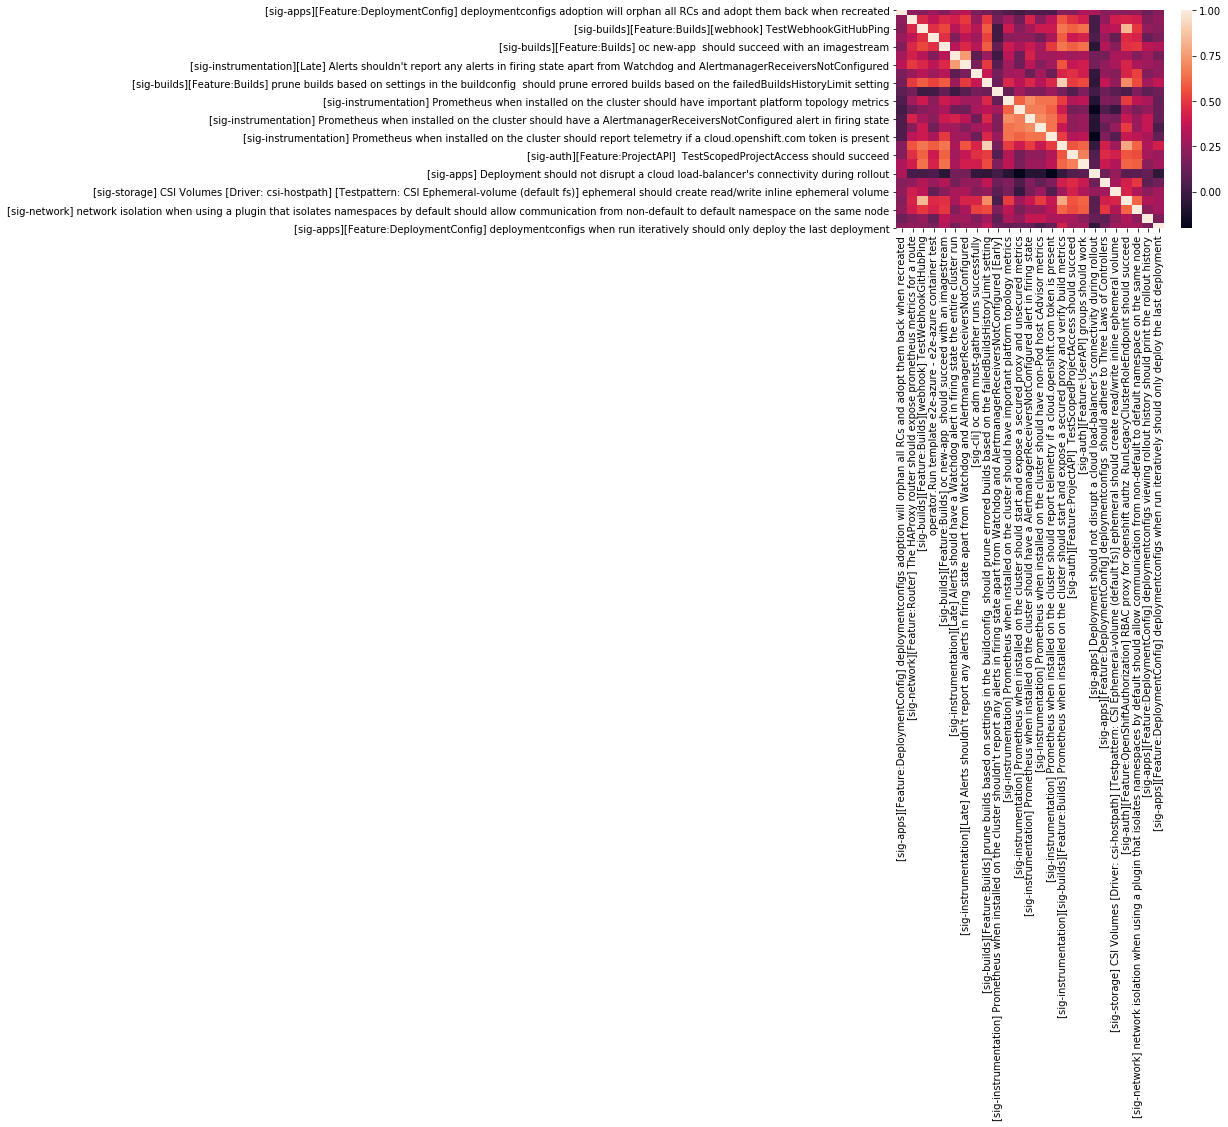

In [21]:
sn.heatmap(corr_matrix.iloc[0:25, 0:25])
plt.show()

### Find highly correlated failure sets

Going thorough a 900 X 900 heatmap is probably not the most efficient way to find failure groups. Let's iterate through the correlation matrix and for each test, collect those tests that have a correlation coefficient of 0.9 or higher. 

In [22]:
# For each feature, find the other features that are correlated by more than 0.9
top_correlation = {}

for c in corr_matrix.columns:
    top_correlation[c] = []
    series = corr_matrix.loc[c]

    for i, s in enumerate(series):
        if s > 0.90 and series.index[i] != c:
            top_correlation[c].append((series.index[i], s))

len(top_correlation)

976

### Examine Correlation Sets
Then to make things easier, lets ignore all the tests for which there are no highly correlated tests. 

Finally lets look at the output of this and examine one of our sets of highly correlated test failures. 

In [23]:
pd.set_option("display.max_colwidth", 150)
# top_correlation has a number of empty rows as not all tests have high correlations with others,
# lets grab only the sets that do
corr_sets = []
for i in top_correlation.items():
    if len(i[1]) >= 1:
        corr_sets.append(i)
print(f"{len(corr_sets)} sets of correlated tests \n")
print(f"Feature of interest: {corr_sets[1][0]}")
pd.DataFrame(corr_sets[1][1], columns=["test_name", "correlation coefficient"])

186 sets of correlated tests 

Feature of interest: [sig-builds][Feature:Builds] prune builds based on settings in the buildconfig  should prune errored builds based on the failedBuildsHistoryLimit setting


,test_name,correlation coefficient
0,[sig-instrumentation][sig-builds][Feature:Builds] Prometheus when installed on the cluster should start and expose a secured proxy and verify buil...,0.908153
1,[sig-auth][Feature:RoleBindingRestrictions] RoleBindingRestrictions should be functional Rolebinding restrictions tests single project should suc...,0.908153
2,[sig-apps][Feature:OpenShiftControllerManager] TestTriggers_configChange,0.908153
3,[sig-auth][Feature:OpenShiftAuthorization] authorization TestClusterReaderCoverage should succeed,0.908153
4,[sig-auth][Feature:OpenShiftAuthorization] self-SAR compatibility TestSelfSubjectAccessReviewsNonExistingNamespace should succeed,0.908153


### Validate correlation set

We can see from the output above that the test `[sig-builds][Feature:Builds] prune builds based on settings in the buildconfig  should prune errored builds based on the failedBuildsHistoryLimit setting` is highly correlated with these 5 other tests. They appear to cooccur almost all of the time (0.9). However, lets just double check and make sure this isn't a one-off occurrence.  

In [24]:
test_name = (
    "[sig-builds][Feature:Builds] prune builds based on settings in the buildconfig  "
    "should prune errored builds based on the failedBuildsHistoryLimit setting"
)
num = occurrence_count.loc[test_name]
print(f"{num} : the number of times this test failed in our data set")

6 : the number of times this test failed in our data set


In [25]:
lst = []
focus = corr_sets[1][1]
for j in focus:
    lst.append((j[0], occurrence_count.loc[j[0]]))

pd.DataFrame(lst, columns=["test_name", "num_occurrences"])

,test_name,num_occurrences
0,[sig-instrumentation][sig-builds][Feature:Builds] Prometheus when installed on the cluster should start and expose a secured proxy and verify buil...,5
1,[sig-auth][Feature:RoleBindingRestrictions] RoleBindingRestrictions should be functional Rolebinding restrictions tests single project should suc...,5
2,[sig-apps][Feature:OpenShiftControllerManager] TestTriggers_configChange,5
3,[sig-auth][Feature:OpenShiftAuthorization] authorization TestClusterReaderCoverage should succeed,5
4,[sig-auth][Feature:OpenShiftAuthorization] self-SAR compatibility TestSelfSubjectAccessReviewsNonExistingNamespace should succeed,5


### Results 

**Here we see that each test failure occurs in 5 different jobs, of which we know that no 2 that are exactly the same. These 5 test almost always fail in conjunction with "prune builds...".** 

Since we see that all of these failures occur in multiple jobs across the dataset, it provides some validity to the claim that these tests are related by the same underlying cause.


### Add job run urls 

In order to help the end-user diagnose the underlying cause driving this set of test failures we would also like to add links to the specific job runs where these failure sets are occurring. 

In order to do this, we need to return to our original dataframe to find the url column associated with our failedTestNames. And then match the urls for cases in which all of our test failure sets fail on the same run. 


In [37]:
failure_groups.head(2)

,job,url,testGridJobUrl,testFailures,failedTestNames,failed,hasUnknownFailures,succeeded
0,release-openshift-origin-installer-e2e-azure-4.6,https://prow.svc.ci.openshift.org/view/gcs/origin-ci-test/logs/release-openshift-origin-installer-e2e-azure-4.6/1291269757735014400,https://testgrid.k8s.io/redhat-openshift-ocp-release-4.6-blocking#release-openshift-origin-installer-e2e-azure-4.6,371,"[Overall, [sig-apps][Feature:DeploymentConfig] deploymentconfigs adoption will orphan all RCs and adopt them back when recreated, [sig-network][Fe...",True,True,False
1,release-openshift-ocp-installer-e2e-aws-ovn-4.6,https://prow.svc.ci.openshift.org/view/gcs/origin-ci-test/logs/release-openshift-ocp-installer-e2e-aws-ovn-4.6/1291592782258900992,https://testgrid.k8s.io/redhat-openshift-ocp-release-4.6-informing#release-openshift-ocp-installer-e2e-aws-ovn-4.6,352,"[Overall, [sig-arch] Managed cluster should have no crashlooping pods in core namespaces over four minutes, [sig-arch][Early] Managed cluster shou...",True,True,False


In [44]:
all_urls = []

for failure_group in corr_sets:
    urls = []
    group = failure_group[1]
    group = [x[0] for x in group]
    group.extend([failure_group[0]])
    sets = set(group)

    for k, g in enumerate(failure_groups.failedTestNames):
        g = set(g)
        if sets.intersection(g) == sets:
            urls.append(failure_groups.url[k])

    all_urls.append(urls)
print(corr_sets[1][0])
pd.Series(all_urls[1])

[sig-builds][Feature:Builds] prune builds based on settings in the buildconfig  should prune errored builds based on the failedBuildsHistoryLimit setting


0    https://prow.svc.ci.openshift.org/view/gcs/origin-ci-test/logs/release-openshift-origin-installer-e2e-azure-4.6/1291269757735014400
1       https://prow.svc.ci.openshift.org/view/gcs/origin-ci-test/logs/release-openshift-ocp-installer-e2e-azure-4.6/1291835183837745152
2    https://prow.svc.ci.openshift.org/view/gcs/origin-ci-test/logs/release-openshift-origin-installer-e2e-azure-4.6/1291480293290545152
3       https://prow.svc.ci.openshift.org/view/gcs/origin-ci-test/logs/release-openshift-ocp-installer-e2e-azure-4.6/1290553685616627712
4    https://prow.svc.ci.openshift.org/view/gcs/origin-ci-test/logs/release-openshift-origin-installer-e2e-azure-4.6/1290697393284583424
dtype: object

### Save Data To CSV

In [28]:
save = pd.DataFrame(corr_sets, columns=["test_name", "correlated_tests"])
save["urls"] = all_urls
save.to_csv("../../../data/interim/correlation_sets.csv")
save.head()

,test_name,correlated_tests,urls
0,[sig-builds][Feature:Builds] oc new-app should succeed with an imagestream,"[([sig-apps][Feature:OpenShiftControllerManager] TestTriggers_MultipleICTs, 0.920985497016262)]","[https://prow.svc.ci.openshift.org/view/gcs/origin-ci-test/logs/release-openshift-origin-installer-e2e-azure-4.6/1291269757735014400, https://prow..."
1,[sig-builds][Feature:Builds] prune builds based on settings in the buildconfig should prune errored builds based on the failedBuildsHistoryLimit ...,[([sig-instrumentation][sig-builds][Feature:Builds] Prometheus when installed on the cluster should start and expose a secured proxy and verify bu...,"[https://prow.svc.ci.openshift.org/view/gcs/origin-ci-test/logs/release-openshift-origin-installer-e2e-azure-4.6/1291269757735014400, https://prow..."
2,[sig-instrumentation][sig-builds][Feature:Builds] Prometheus when installed on the cluster should start and expose a secured proxy and verify buil...,[([sig-builds][Feature:Builds] prune builds based on settings in the buildconfig should prune errored builds based on the failedBuildsHistoryLimi...,"[https://prow.svc.ci.openshift.org/view/gcs/origin-ci-test/logs/release-openshift-origin-installer-e2e-azure-4.6/1291269757735014400, https://prow..."
3,[sig-auth][Feature:UserAPI] groups should work,[([sig-auth][Feature:RoleBindingRestrictions] RoleBindingRestrictions should be functional Create a rolebinding that also contains system:non-exi...,"[https://prow.svc.ci.openshift.org/view/gcs/origin-ci-test/logs/release-openshift-origin-installer-e2e-azure-4.6/1291269757735014400, https://prow..."
4,[sig-auth][Feature:OpenShiftAuthorization] RBAC proxy for openshift authz RunLegacyClusterRoleEndpoint should succeed,"[([sig-auth][Feature:OpenShiftAuthorization] scopes TestUnknownScopes should succeed, 0.9081532183730032)]","[https://prow.svc.ci.openshift.org/view/gcs/origin-ci-test/logs/release-openshift-origin-installer-e2e-azure-4.6/1291269757735014400, https://prow..."


### Conclusion

The above notebook outlines to take a sippydata.json file for a specific time period and identify correlated failures along with the the urls for the specific instances where the failures all occurred together.

### Next steps:

This is a rather small dataset (~100 jobs) we may be able to get a better signal on test failure correlation if we had many more examples to use. 

We could also start to look at how stable these failure set are, and monitor how they drift overtime.  